# Introduction
Source code for exercise 3 - Fine-tuning Language Model

## Set up

In [1]:
!pip install transformers datasets torch matplotlib seaborn

In [2]:
from datasets import load_dataset
from transformers import BertForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
import torch

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cuda:0


In [4]:
# Load dataset
dataset = load_dataset('ag_news')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

## Description of dataset

In [6]:
# 1. Check the structure (Splits)
print(dataset)

# 2. Check the class names
features = dataset['train'].features
print(f"Classes: {features['label'].names}")

# 3. Look at a sample structure
print(f"Sample text: {dataset['train'][0]['text']}")
print(f"Sample label: {dataset['train'][0]['label']} ({features['label'].names[dataset['train'][0]['label']]})")

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})
Classes: ['World', 'Sports', 'Business', 'Sci/Tech']
Sample text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Sample label: 2 (Business)


## 3.2 Stats and example

In [7]:
import pandas as pd

class_names = dataset['train'].features['label'].names

train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

def get_stats(df):
    # Calculate samples per class
    class_counts = df.value_counts('label')

    dist = {class_names[i]: int(class_counts[i]) for i in range(len(class_names))}

    # Calculate text length statistics (number of characters)
    df['text_len'] = df['text'].apply(len)
    avg_len = df['text_len'].mean()

    return dist, avg_len

# 2. Generate Statistics
train_dist, train_avg_len = get_stats(train_df)
test_dist, test_avg_len = get_stats(test_df)

print("--- Summary Statistics ---")
print(f"Total Training Samples: {len(dataset['train'])}")
print(f"Total Testing Samples: {len(dataset['test'])}")
print(f"\nTraining Class Distribution: {train_dist}")
print(f"Testing Class Distribution: {test_dist}")
print(f"\nAvg. Text Length (Train): {train_avg_len:.2f} characters")

# 3. Representative Examples
print("\n--- Representative Examples ---")
for i in range(len(class_names)):
  example = train_df[train_df['label'] == i].iloc[0]['text']
  print(f'{class_names[i]}: {example}')



--- Summary Statistics ---
Total Training Samples: 120000
Total Testing Samples: 7600

Training Class Distribution: {'World': 30000, 'Sports': 30000, 'Business': 30000, 'Sci/Tech': 30000}
Testing Class Distribution: {'World': 1900, 'Sports': 1900, 'Business': 1900, 'Sci/Tech': 1900}

Avg. Text Length (Train): 236.48 characters

--- Representative Examples ---
World: Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuelans turned out early\and in large numbers on Sunday to vote in a historic referendum\that will either remove left-wing President Hugo Chavez from\office or give him a new mandate to govern for the next two\years.
Sports: Phelps, Thorpe Advance in 200 Freestyle (AP) AP - Michael Phelps took care of qualifying for the Olympic 200-meter freestyle semifinals Sunday, and then found out he had been added to the American team for the evening's 400 freestyle relay final. Phelps' rivals Ian Thorpe and Pieter van den Hoogenband and teammate Klete Keller w

## Fine tuning

In [8]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset

# Load dataset
dataset = load_dataset('ag_news')

# Load model and tokenizer
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Preprocess data
def preprocess_function(examples):
    # Only tokenize and truncate, padding will be handled by DataCollatorWithPadding
    tokenized_inputs = tokenizer(examples['text'], truncation=True)
    tokenized_inputs["labels"] = examples["label"] # Add labels back as Trainer expects them
    return tokenized_inputs

# Apply preprocessing
encoded_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names # This removes 'text' and 'label'
)

# Initialize DataCollatorWithPadding
# This collator will pad the sequences to the longest in each batch and convert to PyTorch tensors
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

# Initialize Trainer with the data_collator
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    data_collator=data_collator # Pass the data collator here
)

# Start training
trainer.train()

trainer.save_model("./fine-tuned-bert")
tokenizer.save_pretrained("./fine-tuned-bert")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: esintao (esintao-university-of-copenhagen) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.197800,0.178479
2,0.131700,0.183001
3,0.079600,0.225745


('./fine-tuned-bert/tokenizer_config.json',
 './fine-tuned-bert/special_tokens_map.json',
 './fine-tuned-bert/vocab.txt',
 './fine-tuned-bert/added_tokens.json',
 './fine-tuned-bert/tokenizer.json')

In [12]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def get_attention_map(model_path, text, is_remote=True):
    """Extracts attention from the last layer for a given text."""
    if is_remote:
        model = BertForSequenceClassification.from_pretrained(model_path, output_attentions=True)
    else:
        model = BertForSequenceClassification.from_pretrained(model_path, output_attentions=True)

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)

    # attentions shape: (layer, batch, head, seq_len, seq_len)
    # Get last layer [-1], first batch [0], and average across all 12 heads
    last_layer_attn = outputs.attentions[-1][0].mean(dim=0).detach().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    return last_layer_attn, tokens

def plot_attention(attn, tokens, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
    plt.title(title)
    plt.show()


# Examples

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


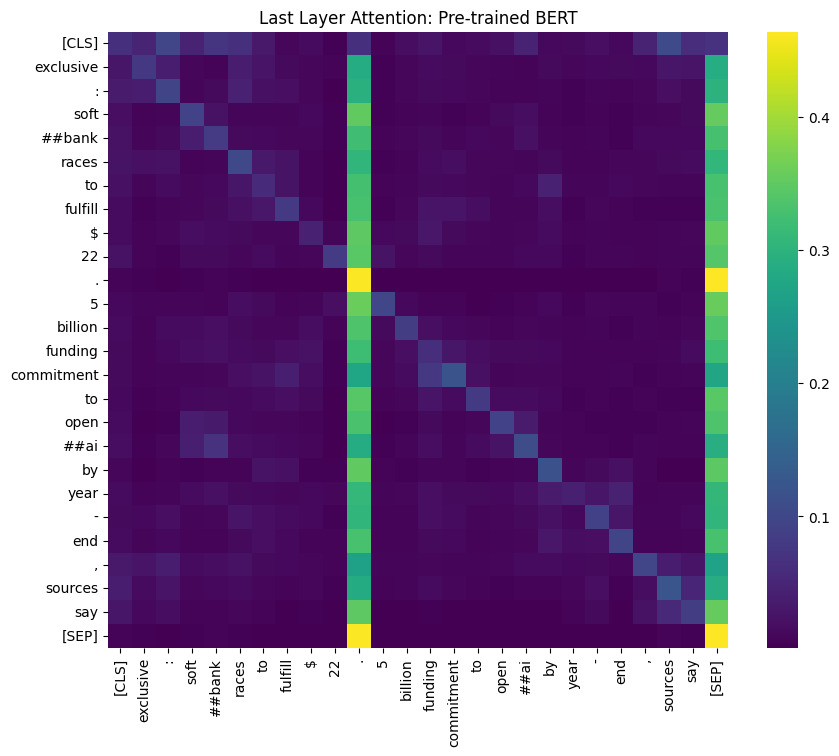

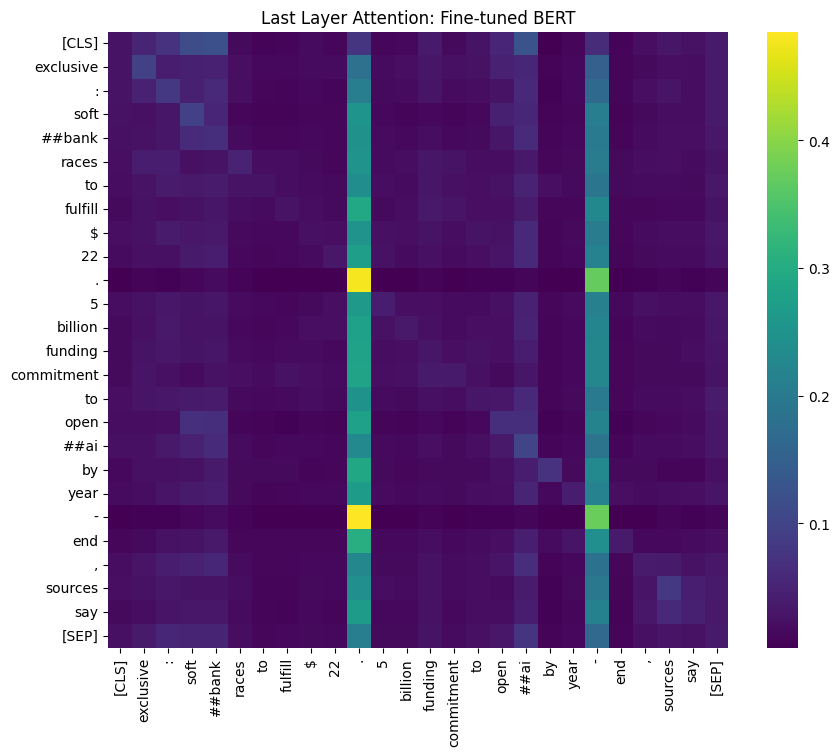

In [15]:
# Example sentence for business
sample_text = "Exclusive: SoftBank races to fulfill $22.5 billion funding commitment to OpenAI by year-end, sources say"

# 1. Visualize Pre-trained
attn_pre, tokens = get_attention_map("bert-base-uncased", sample_text)
plot_attention(attn_pre, tokens, "Last Layer Attention: Pre-trained BERT")

# 2. Visualize Fine-tuned
attn_fine, _ = get_attention_map("./fine-tuned-bert", sample_text, is_remote=False)
plot_attention(attn_fine, tokens, "Last Layer Attention: Fine-tuned BERT")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


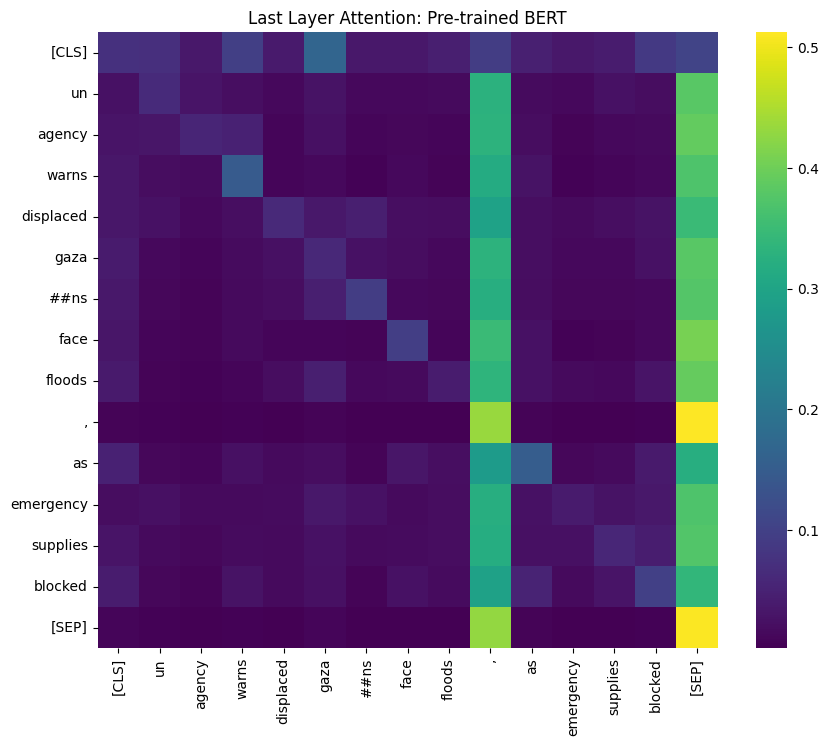

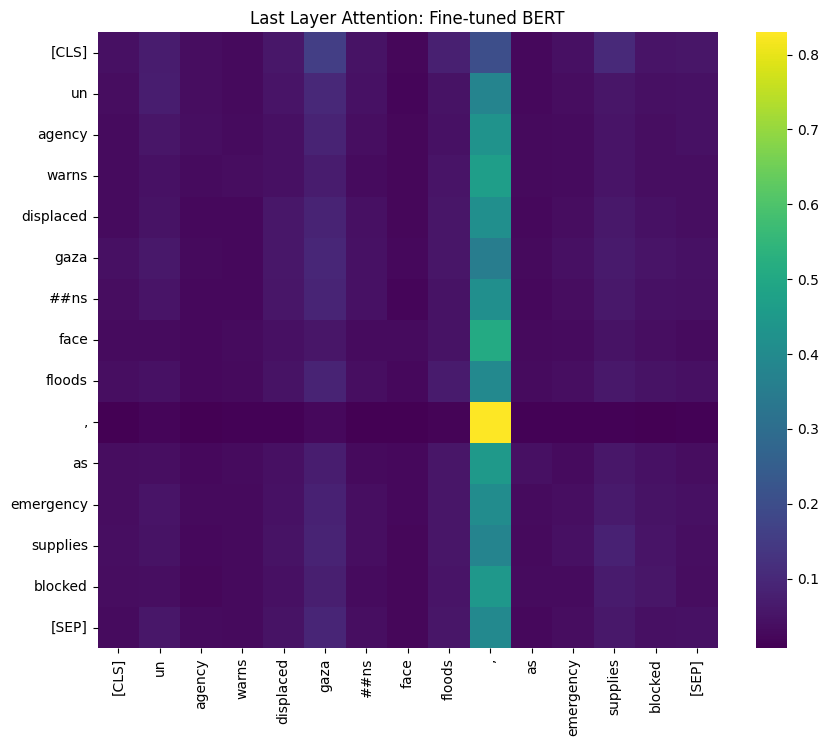

In [19]:
# Example sentence for world
sample_text = "UN agency warns displaced Gazans face floods, as emergency supplies blocked"
# 1. Visualize Pre-trained
attn_pre, tokens = get_attention_map("bert-base-uncased", sample_text)
plot_attention(attn_pre, tokens, "Last Layer Attention: Pre-trained BERT")

# 2. Visualize Fine-tuned
attn_fine, _ = get_attention_map("./fine-tuned-bert", sample_text, is_remote=False)
plot_attention(attn_fine, tokens, "Last Layer Attention: Fine-tuned BERT")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


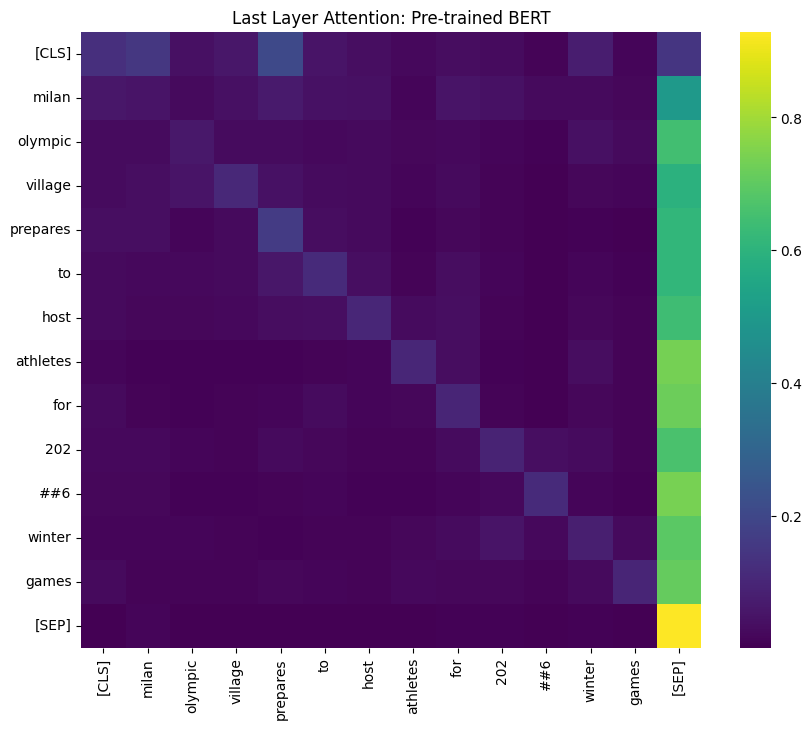

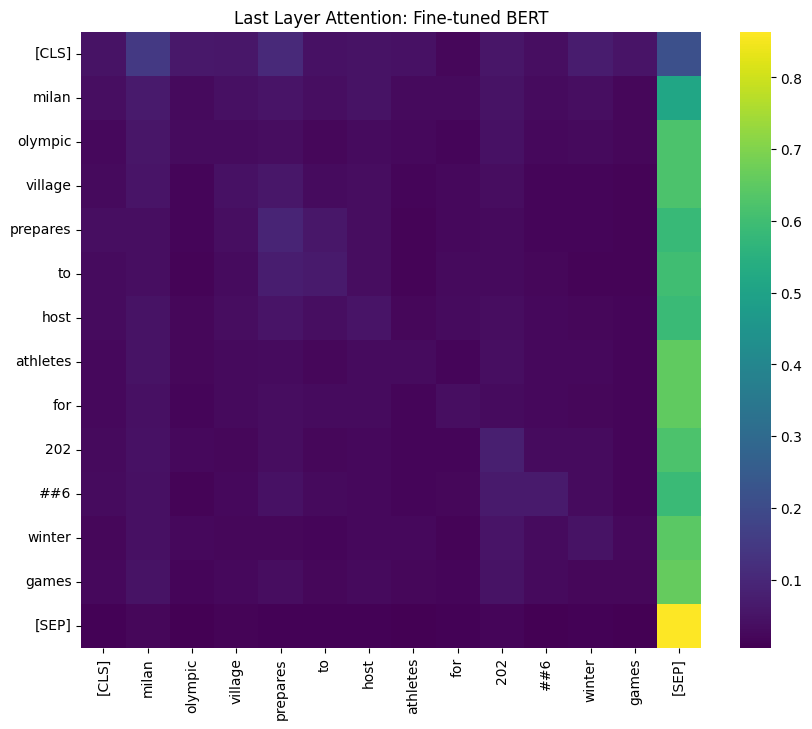

In [23]:
# Example sentence for sports
sample_text = "Milan Olympic Village prepares to host athletes for 2026 Winter Games"

# 1. Visualize Pre-trained
attn_pre, tokens = get_attention_map("bert-base-uncased", sample_text)
plot_attention(attn_pre, tokens, "Last Layer Attention: Pre-trained BERT")

# 2. Visualize Fine-tuned
attn_fine, _ = get_attention_map("./fine-tuned-bert", sample_text, is_remote=False)
plot_attention(attn_fine, tokens, "Last Layer Attention: Fine-tuned BERT")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


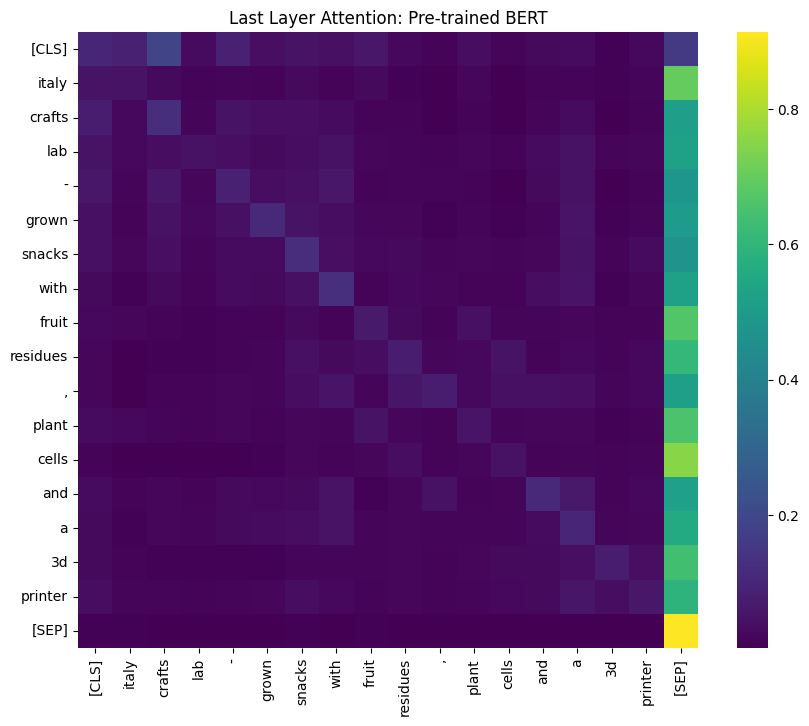

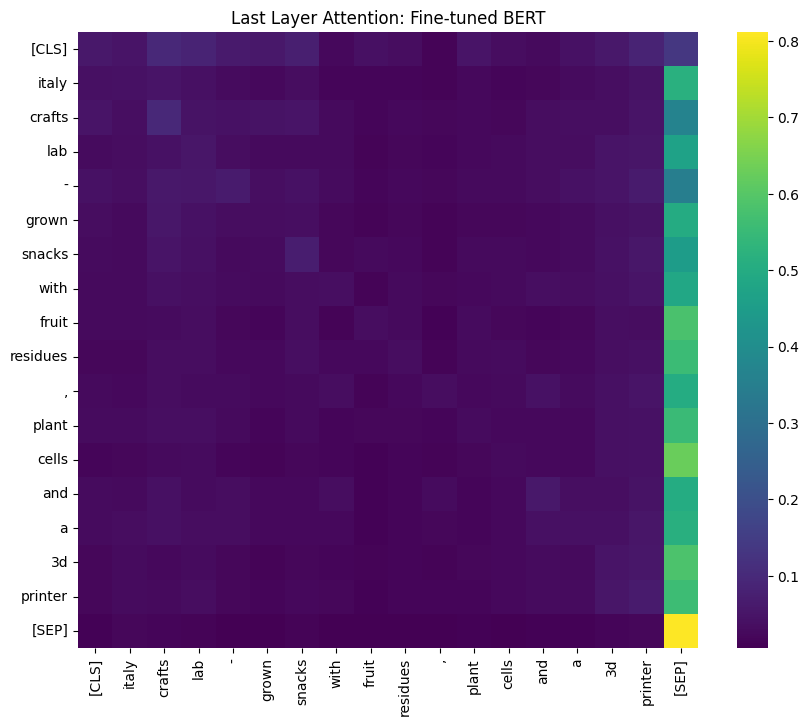

In [22]:
# Example sentence for science
sample_text = "Italy crafts lab-grown snacks with fruit residues, plant cells and a 3D printer"

# 1. Visualize Pre-trained
attn_pre, tokens = get_attention_map("bert-base-uncased", sample_text)
plot_attention(attn_pre, tokens, "Last Layer Attention: Pre-trained BERT")

# 2. Visualize Fine-tuned
attn_fine, _ = get_attention_map("./fine-tuned-bert", sample_text, is_remote=False)
plot_attention(attn_fine, tokens, "Last Layer Attention: Fine-tuned BERT")